<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#This-notebooks-contains-my-analysis-of-QPCR-data-and-flags-samples-in-BombusMetadata-as-C.-bombi-+-or--" data-toc-modified-id="This-notebooks-contains-my-analysis-of-QPCR-data-and-flags-samples-in-BombusMetadata-as-C.-bombi-+-or---1"><span class="toc-item-num">1&nbsp;&nbsp;</span>This notebooks contains my analysis of QPCR data and flags samples in BombusMetadata as C. bombi + or -</a></span></li><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Batches" data-toc-modified-id="Batches-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Batches</a></span><ul class="toc-item"><li><span><a href="#2017" data-toc-modified-id="2017-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>2017</a></span></li><li><span><a href="#2018" data-toc-modified-id="2018-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>2018</a></span></li><li><span><a href="#2019" data-toc-modified-id="2019-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>2019</a></span></li><li><span><a href="#Total-Positivity-Rate" data-toc-modified-id="Total-Positivity-Rate-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Total Positivity Rate</a></span></li></ul></li><li><span><a href="#Singles" data-toc-modified-id="Singles-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Singles</a></span></li><li><span><a href="#Write-to-metadata" data-toc-modified-id="Write-to-metadata-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Write to metadata</a></span></li><li><span><a href="#Check-for-relationship-between-detection-rate-and-sample-concentration" data-toc-modified-id="Check-for-relationship-between-detection-rate-and-sample-concentration-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Check for relationship between detection rate and sample concentration</a></span></li><li><span><a href="#Write-back" data-toc-modified-id="Write-back-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Write back</a></span></li></ul></li></ul></div>

## This notebooks contains my analysis of QPCR data and flags samples in BombusMetadata as C. bombi + or -

- First notebook for the thesis

In [3]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm 
datapath = '../data'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Helper Functions

In [3]:
def standardPlot(df, cq, sq, rows):
    '''
    df = qpcr dataset
    cq = cq column name
    sq = sq column name
    rows = array of rows containing standards, ex np.arange(0,6)
    Calculates reaction efficiency and r2, plots standards
    returns (fig, ax, efficiency, reg object)
    '''
    # scatter the standards 
    df2 = df.loc[rows][[sq, cq]]
    df2 = df2.dropna(subset = [cq])
    log10sq = df2[sq].apply(np.log10).to_numpy()
    #print(log10sq)
    cq = df2[cq]
    #print(df2)
    # regress
    reg = LinearRegression().fit(log10sq.reshape(-1,1),cq)
    cqpred = reg.predict(log10sq.reshape(-1,1))
    #print(cqpred)
    r2 = r2_score(cq, cqpred)
    e = (10** (-1/reg.coef_[0]) -1 )* 100
    fig, ax = plt.subplots()
    ax.scatter(log10sq, cq)
    ax.plot(log10sq, cqpred)
    ax.set_xlabel("Log 10 SQ")
    ax.set_ylabel("Cq")
    fig.suptitle("Standard Plot: r2 = %.2f, Eff = %.2f" %(r2, e))
    return(fig, ax, e, reg)

def calcResults(df,content,sqCol,cqCol,unkRows,reg,minStand):
    '''
    calculates starting quantities
    calculates mean sq and cq
    returns updated table
    '''
    # set mean cq same for everything 
    df["MeanCQ"] = df[content].apply(lambda x: df[df[content] == x][cqCol].mean())
    SDCQ = df[content].apply(lambda x: df[df[content] == x][cqCol].std())
    #df['SDCQ'] = 0
    df['SDCQ'] = SDCQ
    # predict sqs for the unknowns
    df.loc[unkRows, sqCol] = df.loc[unkRows,cqCol].apply(lambda x: 10 ** ((x-reg.intercept_)/reg.coef_[0]))
    # mean sq is calc same everywhere
    df['MeanSQ'] = df[content].apply(lambda x: df[df[content] == x][sqCol].mean())   
    df['Positive'] = df['MeanCQ'].apply(lambda x: x <= df[df[content] == minStand]['MeanCQ'].to_numpy()[0])

def getResults(df,unkRows, start, bSize, replicates, sqCol):
    '''
    Calculates which individual samples need to be tested and which are negative
    df: the dataframe, unkRows: rows with unknowns, start: the first batch tested
    on the plate, bSize: batch size, replicates: number of technical reps
    Returns arrays of negative samples and samples needed to be run in single (neg, flag, concs)
    '''
    _ = df.loc[unkRows[::replicates]]
    _['i'] = np.arange(_.shape[0])
    _['i'] = _['i']+start
    _['samps'] = _['i'].apply(lambda x: np.arange((x-1)*bSize,x*bSize ) + 1)
    neg = np.stack(_[_['Positive']==False]['samps'].to_numpy()).flatten()
    flag = np.stack(_[_['Positive']==True]['samps'].to_numpy()).flatten()
    #concs = np.stack(_[sqCol].apply(lambda x: [x]*bSize ).to_numpy()).flatten()
    concs = np.stack(_[_['Positive']==True][sqCol].to_numpy()).flatten()
    return(neg, flag,concs)

def getResults_df(df,unkRows, start, bSize, replicates, sqCol):
    _ = df.loc[unkRows[::replicates]]
    _['i'] = np.arange(_.shape[0])
    _['i'] = _['i']+start
    _['samps'] = _['i'].apply(lambda x: np.arange((x-1)*bSize,x*bSize ) + 1)
    return _

def calcPosRate(bsize, neg, flag):
    ''' 
    Uses the math described in 2017 to estimate underlying 
    positivity rate from batch positivity rate
    '''
    s = (neg.shape[0] + flag.shape[0])
    
    return 1 - (1 - flag.shape[0]/ s)**(1/bsize)

## Analysis

### Batches

All separated by year, plates not completely full

#### 2017

2017 bees were named in numerical order so I chose to keep them in this order for qpcr. However, B0132 and B0148 both failed DNA extraction, leaving 168 of 170 bees for QPCR. I ran them in 42 batches of 4. BombusMetadata reflects the order they were run for batches in "QPCR_Order". 

Read the data

In [4]:
b2017 = pd.read_csv(os.path.join(datapath, "qpcr/B4_2017_1_172.csv"))

In [5]:
b2017.loc[0:1, "Content"] = "E7"
b2017.loc[2:3, "Content"] = "E4"
b2017.loc[4:5, "Content"] = "E3"

**Check batch quality, flag samples**

In [6]:
test = getResults_df(b2017, np.arange(8,92),1,4,2,"Starting Quantity (SQ)" )

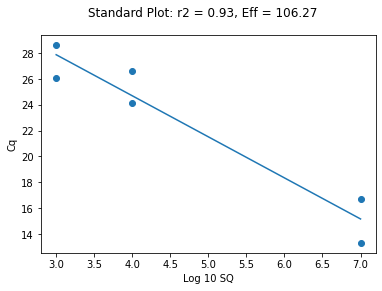

In [7]:
# check the batches
fig, ax, e, reg = standardPlot(b2017,"Cq","Starting Quantity (SQ)", np.arange(0,6))
calcResults(b2017,'Content',"Starting Quantity (SQ)","Cq", np.arange(8,92),reg,'E3' )
b2017_neg, b2017_flag,b2017_conc = getResults(b2017, np.arange(8,92),1,4,2,"Starting Quantity (SQ)" )

**Positivity Rate**

First looking at batch rate and then estimating the underlying population. Batches should test positive when at least one member is positive. The probability of a batch testing positive is thus:

$\sum_{n=1}^b (^b_n) p^n (1-p)^{b-n}$ 

or $1 - (1-p)^{b}$ 

where $b$ is the batch size and $p$ is the probability of a sample having a *C. bombi* infection.

The expected number of positive batches, $x$, where $s$ is the total number of samples is thus:

$x = \frac{s}{b} \cdot (1 - (1-p)^{b})$

We can then solve backwards for $p$:

$1 - (1 - \frac{bx}{s})^{\frac1b} = p$

**Check the batch positivity rate and estimate the underlying sample positivity rate**

In [8]:
print(b2017_neg.shape[0] / 168)

calcPosRate(4, b2017_neg, b2017_flag)

0.09523809523809523


0.44447619319764176

quantity of all batches 

In [9]:
all_samp_quants17 = [a for b in b2017.loc[np.arange(8,92)[::2]]['MeanSQ'].apply(lambda x: [x,x,x,
    x]).to_list() for a in b]

In [10]:
len(all_samp_quants17)

168

#### 2018

I ran the 2018 bees in the order they are stored. Their order is reflected in BombusMetadata. It is not the same as #SampleID (although that is also numeric). In total, there are 235 bees from 2017. 235 divides into 58 full batches of 4 and one of 3. I ran the triple last. I originally ran 1-116 together and 117-235 together. However, the first plate had a poor efficiency so I ran it again. The second time, I made an error in my notes and accidentally included batch 117-120, so this batch appears on both plates. They agree. Both plates have 30 batches. 

In [11]:
b20181 = pd.read_csv(os.path.join(datapath,"qpcr/B4_2018_1_120.csv"))
b20181.loc[0:1, "Content"] = "E7"
b20181.loc[2:3, "Content"] = "E4"
b20181.loc[4:5, "Content"] = "E3"

b20182 = pd.read_csv(os.path.join(datapath,"qpcr/B42018_117_235_20201125.csv"))
b20182 = b20182.replace('Undetermined', np.nan)
b20182['Cт'] = b20182['Cт'].apply(float)
b20182.loc[0:1, "Sample Name"] = "E7"
b20182.loc[2:3, "Sample Name"] = "E4"
b20182.loc[4:5, "Sample Name"] = "E3"

**Check batch quality, flag samples**

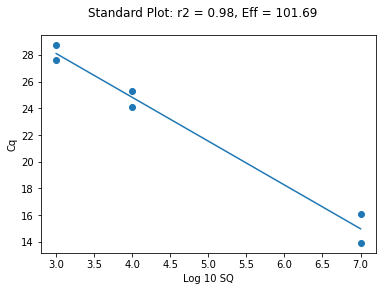

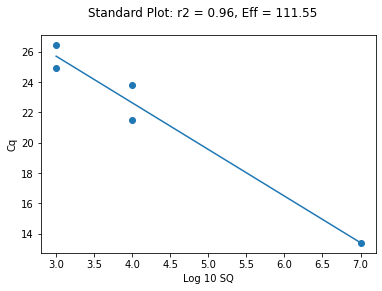

In [12]:
# efficiency sucks on both of these
fig, ax, e, reg = standardPlot(b20181,"Cq","Starting Quantity (SQ)", np.arange(0,6))
calcResults(b20181,'Content',"Starting Quantity (SQ)","Cq", np.arange(8,68),reg,'E3' )
b20181_neg, b20181_flag,b20181_conc = getResults(b20181, np.arange(8,68),1,4,2,"Content" )


fig, ax, e, reg = standardPlot(b20182,"Cт","Quantity", np.arange(0,6))
calcResults(b20182,'Sample Name',"Quantity","Cт", np.arange(8,68),reg,'E3' )
b20182_neg, b20182_flag,b20182_conc = getResults(b20182, np.arange(8,68),30,4,2, "Quantity" )

**Positivity Rate**

In [13]:
print((b20181_neg.shape[0]+ b20182_neg.shape[0]) / 236)

calcPosRate(4, np.hstack((b20181_neg,b20182_neg)), np.hstack((b20181_flag,b20182_flag)))

0.06779661016949153


0.49186725184538527

**all sample conc**

In [14]:
all_samp_quants18 =[a for b in b20181.loc[np.arange(8,
                    66)[::2]]['MeanSQ'].apply(lambda x: [x,x,x,
    x]).to_list() for a in b]+ \
                              [a for b in b20182.loc[np.arange(8,
                    68)[::2]]['MeanSQ'].apply(lambda x: [x,x,x,
    x]).to_list() for a in b]
all_samp_quants18 = all_samp_quants18[:-1]

#### 2019

In total we have 329 bees from 2019. This comes out to 82 batches and a single. Plate 1 includes an E2 standard and the first 43 batches. Plate 2 has the next 40 batches, including the single. 

Read the data

In [15]:
b20191 = pd.read_csv(os.path.join(datapath,"qpcr/B42019_1_172_20201116.csv"))
b20191.loc[0:1, "Content"] = "E7"
b20191.loc[2:3, "Content"] = "E4"
b20191.loc[4:5, "Content"] = "E3"
b20191.loc[6:7, "Content"] = "E2"

b20192 = pd.read_csv(os.path.join(datapath,"qpcr/B4_2019_173_329.csv"))
b20192.loc[0:1, "Content"] = "E7"
b20192.loc[2:3, "Content"] = "E4"
b20192.loc[4:5, "Content"] = "E3"

**Check batch quality, flag samples**

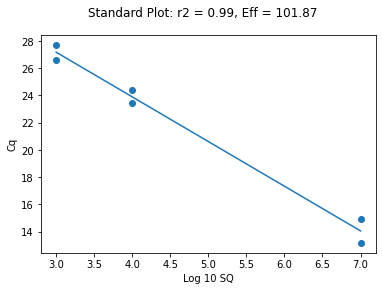

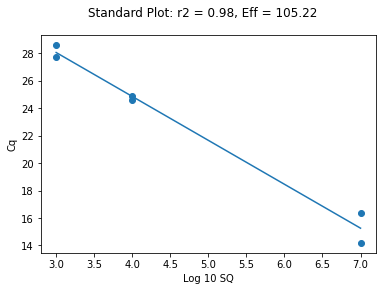

In [16]:
# check the batches
fig, ax, e, reg = standardPlot(b20191,"Cq","Starting Quantity (SQ)", np.arange(0,6))
calcResults(b20191,'Content',"Starting Quantity (SQ)","Cq", np.arange(10,96),reg,'E3' )
b20191_neg, b20191_flag,b20191_conc = getResults(b20191, np.arange(10,96),1,4,2,"Starting Quantity (SQ)" )

fig, ax, e, reg = standardPlot(b20192,"Cq","Starting Quantity (SQ)", np.arange(0,6))
calcResults(b20192,'Content',"Starting Quantity (SQ)","Cq", np.arange(8,88),reg,'E3' )
b20192_neg, b20192_flag,b20192_conc = getResults(b20192, np.arange(8,88),44,4,2,"Starting Quantity (SQ)" )


**Positivity Rate**

In [19]:
b20191[b20191['Content'].str.contains('E')]

,Well,Fluor,Target,Content,Sample,Cq,Starting Quantity (SQ),Melt Temperature,Peak Height,Call,End RFU,MeanCQ,SDCQ,MeanSQ,Positive
0,A01,SYBR,NaN,E7,NaN,14.922893,10000000.0,82.5,410.685271,NaN,2489.634337,14.050360,1.233948,10000000.0,True
1,A02,SYBR,NaN,E7,NaN,13.177827,10000000.0,83.0,394.310179,NaN,1857.000343,14.050360,1.233948,10000000.0,True
2,A03,SYBR,NaN,E4,NaN,24.423043,10000.0,82.5,373.882811,NaN,2204.846400,23.929728,0.697652,10000.0,True
3,A04,SYBR,NaN,E4,NaN,23.436414,10000.0,82.5,359.232481,NaN,2044.880619,23.929728,0.697652,10000.0,True
4,A05,SYBR,NaN,E3,NaN,27.681481,1000.0,82.5,357.494375,NaN,2377.998335,27.143342,0.761043,1000.0,True
5,A06,SYBR,NaN,E3,NaN,26.605204,1000.0,82.5,321.397210,NaN,2009.838133,27.143342,0.761043,1000.0,True
6,A07,SYBR,NaN,E2,NaN,29.228145,100.0,82.5,293.502239,NaN,1939.035558,28.916219,0.441130,100.0,False
7,A08,SYBR,NaN,E2,NaN,28.604293,100.0,82.5,314.031526,NaN,2226.878666,28.916219,0.441130,100.0,False


In [15]:
print((b20191_neg.shape[0]+ b20192_neg.shape[0]) / 332)

calcPosRate(4, np.hstack((b20191_neg,b20192_neg)), np.hstack((b20191_flag,b20192_flag)))

0.3373493975903614


0.23788592090716787

**all sample conc**

In [61]:
all_samp_quants19 =[a for b in b20191.loc[np.arange(10,
                    96)[::2]]['MeanSQ'].apply(lambda x: [x,x,x,
    x]).to_list() for a in b]+ \
                              [a for b in b20192.loc[np.arange(8,
                    88)[::2]]['MeanSQ'].apply(lambda x: [x,x,x,
    x]).to_list() for a in b]
all_samp_quants19 = all_samp_quants19[:-3]

#### Total Positivity Rate 

(batch positivity rate over estimated sample rate)

In [16]:
print((b2017_neg.shape[0] + b20181_neg.shape[0] +
       b20182_neg.shape[0] + b20191_neg.shape[0]+ 
       b20192_neg.shape[0]) / (168+ 236 + 332))

calcPosRate(4, np.hstack((b2017_neg, b20181_neg, b20182_neg,
                          b20191_neg,b20192_neg)),
            np.hstack((b2017_flag, b20181_flag, b20182_flag,
                       b20191_flag,b20192_flag)))

0.1956521739130435


0.3358247420625452

### Singles

All samples from flagged batches were run in triplicate. They are ordered but not separated by year. 

Read the data

In [17]:
os.listdir(os.path.join(datapath,"qpcr/"))

# get the files, store in dictionary by name
files = [f for f in os.listdir(os.path.join(datapath,"qpcr/"))
        if f.startswith("S")]

fdict = dict((f.split(".")[0], pd.read_csv(os.path.join(datapath, "qpcr", f))) for f in files)
# update content 
for k,v in fdict.items():
    year = None
    vals = [["E7",0],["E4",0],["E3",0],["NTC",0]]
    for x in k.split('_'):
        if x[0] == 'S':
            year = int(x[1:])
        else:
            s,f = map(int, x.split('-'))
            vs = list([v, year] for v in range(s, f+1))
            vals.extend(vs)
    vals2 = [None]* (3*len(vals))
    for i in range(3):
        vals2[i::3] = vals
    
    v[['Content', 'Year']] = vals2

**Get Results From Singles**

/var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/ipykernel_93916/3464826743.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


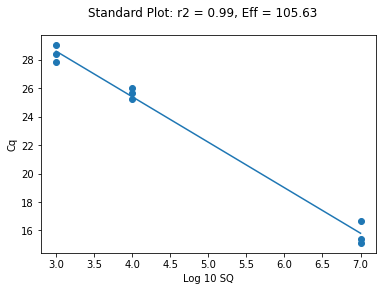

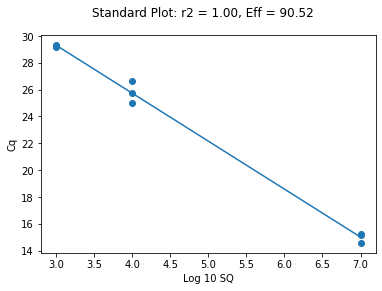

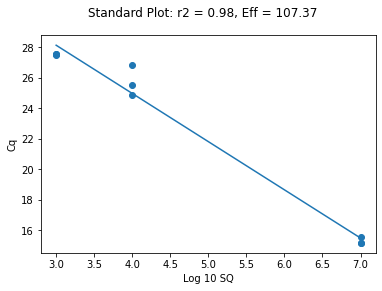

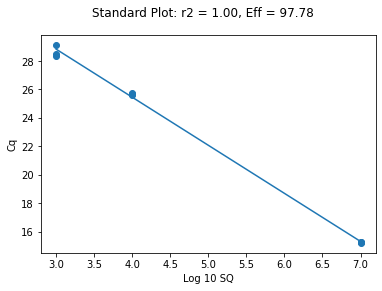

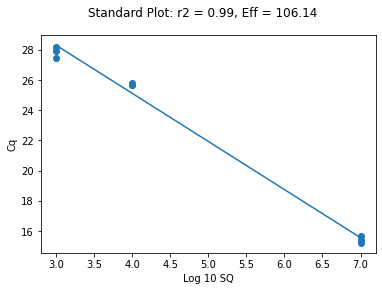

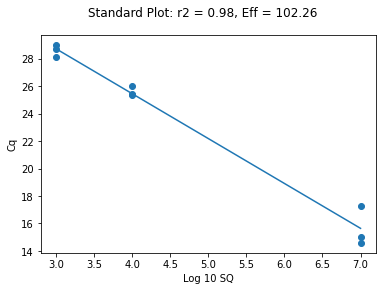

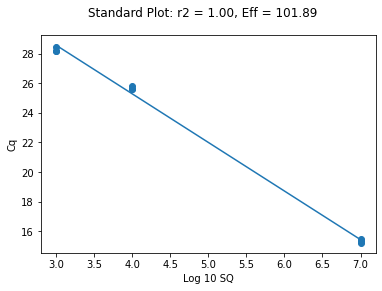

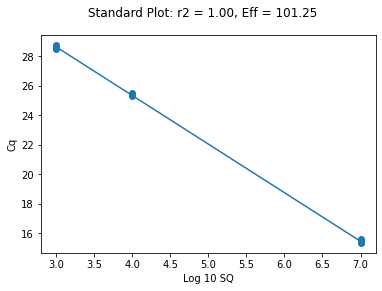

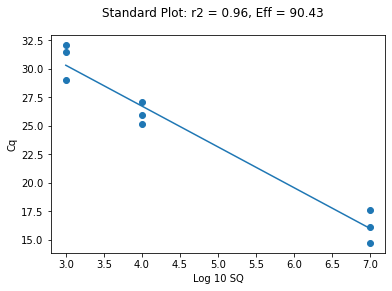

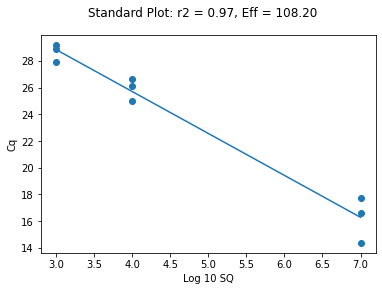

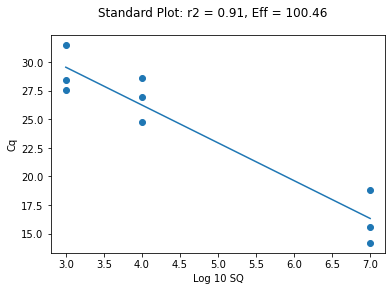

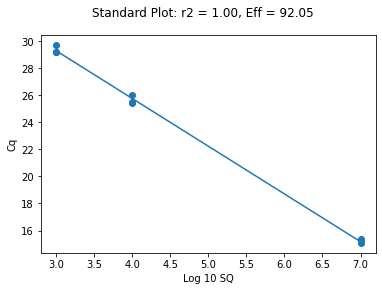

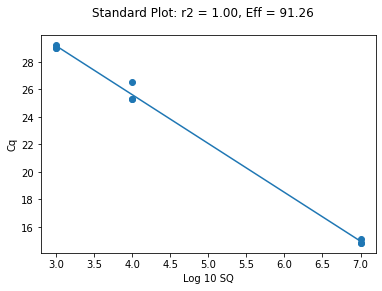

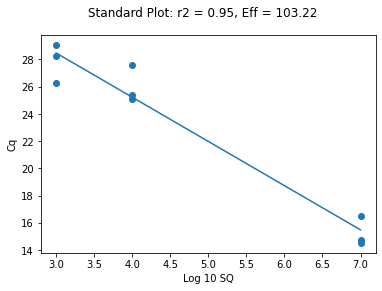

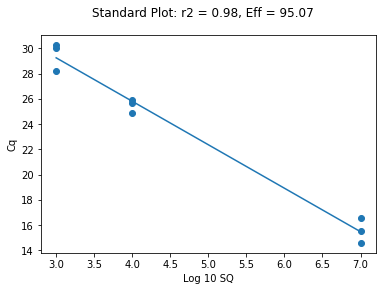

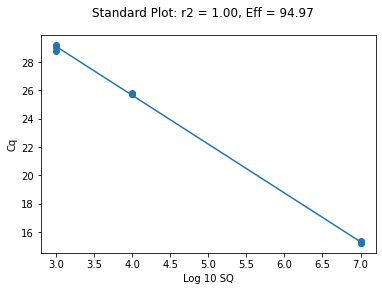

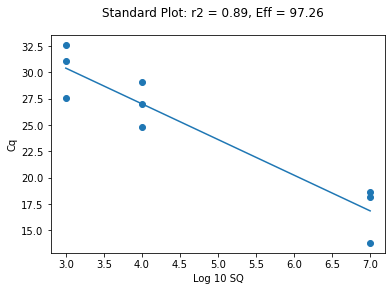

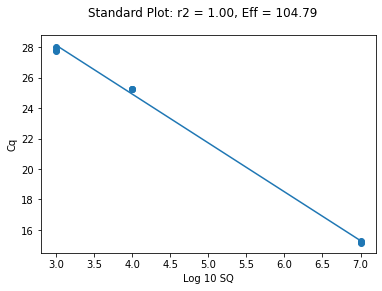

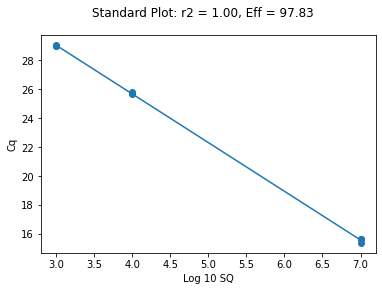

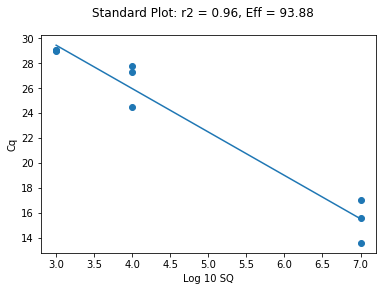

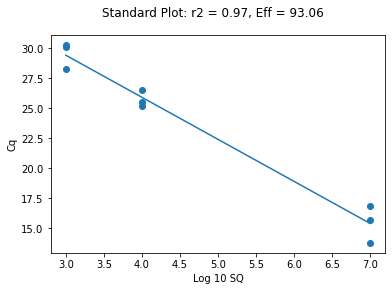

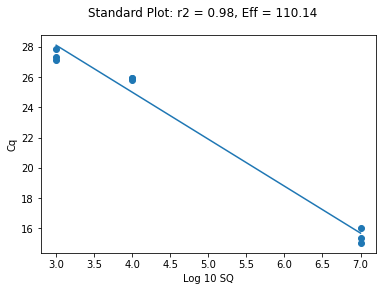

In [18]:
# looks good
rdict = {}
for k,v in fdict.items():
    fig, ax, e, reg = standardPlot(v,"Cq","Starting Quantity (SQ)", np.arange(0,9))
    calcResults(v,'Content',"Starting Quantity (SQ)","Cq", np.arange(9,v.shape[0]),reg,'E3')

### Write to metadata

**Read in the raw sample metadata**

In [19]:
metadf = pd.read_csv(os.path.join(datapath, 'BombusMetadata.tsv'), sep = "\t")

**Fill in results from negative batches**
- All samples from negative batches assumed to be negative
- Infection load estimated as 0

In [20]:
res = {}
res["neg2017"] = b2017_neg
res["neg2018"] = np.hstack((b20181_neg, b20182_neg))
res["neg2019"] = np.hstack((b20191_neg,b20192_neg))

_ = lambda x: False if int(x[1]) in res['neg'+str(int(x[0]))] else np.nan
metadf['Positive'] = metadf[['Year','QPCR_Order']].apply(_, axis = 1)

_ = lambda x: 0 if x == False else np.nan
metadf['CBombiConc'] = metadf['Positive'].apply(_)



**add batch average conc**

In [70]:
res['conc2017'] = all_samp_quants17
res['conc2018'] = all_samp_quants18
res['conc2019'] = all_samp_quants19

_ = lambda x: res['conc'+str(int(x[0]))][int(x[1]-1)]

metadf['batch_conc'] = metadf[['Year','QPCR_Order']].apply(_, axis = 1)


**Get Results From Singles**

**Quantify Infection**

- given concentration of samples in $\frac {ng}{\mu L}$
- given volume of samples (1 $\mu L$)
- calculated estimated starting quantity (SQ)
- $\frac {SQ}{conc.}$ is quantity per $ng$ of gut DNA

In [72]:
for df in fdict.values():
    _ = df[::3][4:][['Content','Year','Starting Quantity (SQ)', 'Positive']]
    metadf =pd.merge(metadf, _, left_on = ['QPCR_Order', 'Year'],
                      right_on = ['Content', 'Year'], how = 'left')
    metadf['Positive'] = metadf[['Positive_x', 'Positive_y']].max(axis = 1)
    metadf['Starting Quantity (SQ)'] = metadf['Starting Quantity (SQ)']/metadf['QPCR_Concentration'].astype('float')
    metadf['CBombiConc'] = metadf[['Starting Quantity (SQ)', 'CBombiConc']].max(axis = 1)
    metadf.drop(['Positive_x', 'Positive_y', 'Starting Quantity (SQ)', 'Content'], axis = 1, inplace = True)

### Check for relationship between detection rate and sample concentration
- Using logistic regression
- No relationship for batches nor singles
- Indicates that sample concentration was not confounding

In [73]:
# get subset
metadf['QPCR_Concentration'] = metadf['QPCR_Concentration'].astype('float')
metadf['QPCR_Order'] = metadf['QPCR_Order'].astype('float')


data = metadf[['QPCR_Concentration','QPCR_Order','Year','Positive']].copy()
data['Batch'] = data['QPCR_Order'].apply(lambda x: int((x-1)/4)+1)
# get avg batch concentration
data['BatchConc'] = data.apply(lambda x: data[(data['Batch']==x['Batch']) &
                                              (data['Year']== x['Year'])]['QPCR_Concentration'].mean(),
                               axis = 1)
# get batch results
bres = {}
bres['neg2017'] = b2017_neg
bres['pos2017'] = b2017_flag
bres["neg2018"] = np.hstack((b20181_neg, b20182_neg))
bres["pos2018"] = np.hstack((b20181_flag, b20182_flag))
bres["neg2019"] = np.hstack((b20191_neg, b20192_neg))
bres["pos2019"] = np.hstack((b20191_flag, b20192_flag))
# fill in with lambda funct
_ = lambda x: 1 if x[1] in bres['pos'+str(int(x[0]))] else 0 if x[1] in bres['neg'+str(int(x[0]))] else np.nan
data['bres'] = data[['Year','QPCR_Order']].apply(_, axis = 1)
# drop na values
datab = data[::4]
data = data.dropna()
# check relationship with batch concentration 
model = sm.GLM.from_formula("bres ~ BatchConc", family = sm.families.Binomial(), data = datab)
result=model.fit()
print(result.summary())

# check sample level  
model = sm.GLM.from_formula("Positive ~ QPCR_Concentration", family = sm.families.Binomial(), data = data)
result=model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   bres   No. Observations:                  183
Model:                            GLM   Df Residuals:                      181
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -90.584
Date:                Mon, 03 Jul 2023   Deviance:                       181.17
Time:                        08:34:51   Pearson chi2:                     183.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001654
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6764      0.524      3.198      0.0

**Infection Severity Frequency Plot**
- Using a log scale with pseudocount

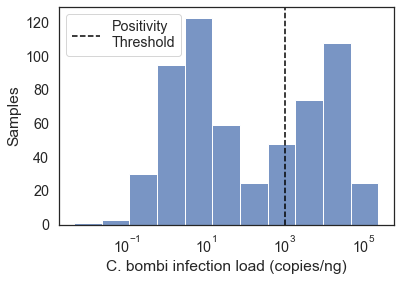

In [31]:
sns.set(font_scale = 1.3, style = 'white')
fig, ax = plt.subplots()
plt.xscale('log')
sns.histplot(data = metadf[metadf['CBombiConc'] > 0], x = 'CBombiConc')
plt.xlabel('C. bombi infection load (copies/ng)')
plt.ylabel('Samples')
plt.axvline(1000, linestyle = '--', color = 'black',label = 'Positivity\nThreshold')
plt.legend()
fig.savefig('CBombi_hist.pdf', bbox_inches='tight', transparent = True, format = 'pdf')

In [29]:
metadf.groupby('Year')['Positive'].value_counts()

Year  Positive
2017  1.0         108
      0.0          60
2018  0.0         128
      1.0         107
2019  0.0         211
      1.0         118
Name: Positive, dtype: int64

### Write back 

In [28]:
metadf.to_csv(os.path.join(datapath, 'BombusMetadata.tsv'), sep = "\t", index = False)

In [85]:
cbombi_df = metadf.set_index('#SampleID')[['batch_conc','CBombiConc',
        'Positive']].copy()
cbombi_df['CBombiConc'].replace(0, np.nan, inplace = True)

In [88]:
cbombi_df.to_csv(os.path.join(datapath, 'cbombi_stats.tsv'), sep = "\t", index = True)